In [1]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install torch torchvision

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install seaborn


   ---------------------------------------- 0.0/294.9 kB ? eta -:--:--
   ---------------------------------------- 0.0/294.9 kB ? eta -:--:--
   ---------------------------------------- 0.0/294.9 kB ? eta -:--:--
   ---------------------------------------- 0.0/294.9 kB ? eta -:--:--
   ---------------------------------------- 0.0/294.9 kB ? eta -:--:--
   ---------------------------------------- 0.0/294.9 kB ? eta -:--:--
   ---- ----------------------------------- 30.7/294.9 kB ? eta -:--:--
   ---- ----------------------------------- 30.7/294.9 kB ? eta -:--:--
   ---- ----------------------------------- 30.7/294.9 kB ? eta -:--:--
   ---- ----------------------------------- 30.7/294.9 kB ? eta -:--:--
   ---- ----------------------------------- 30.7/294.9 kB ? eta -:--:--
   ---- ----------------------------------- 30.7/294.9 kB ? eta -:--:--
   --------- ----------------------------- 71.7/294.9 kB 196.9 kB/s eta 0:00:02
   --------- ----------------------------- 71.7/294.9 kB 196.

In [14]:
pip install scikit-learn


Note: you may need to restart the kernel to use updated packages.


In [15]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from copy import deepcopy

from torchvision import transforms
from torchvision.models import resnet50, ResNet50_Weights

from sklearn.model_selection import train_test_split

from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn

import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
import os
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [16]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [17]:
label_index = {"dry": 0, "normal": 1, "oily": 2}
index_label = {0: "dry", 1: "normal", 2: "oily"}


In [18]:
def create_df(base):
    dd = {"images": [], "labels": []}
    for i in os.listdir(base):
        label = os.path.join(base, i)
        for j in os.listdir(label):
            img = os.path.join(label, j)
            dd["images"] += [img]
            dd["labels"] += [label_index[i]]
    return pd.DataFrame(dd)

In [19]:
import os


In [23]:
train_df = create_df(r'C:\Users\Anindya\Downloads\oil detection\oil detection\Oily-Dry-Skin-Types\train')
val_df = create_df(r'C:\Users\Anindya\Downloads\oil detection\oil detection\Oily-Dry-Skin-Types\valid')
test_df = create_df(r'C:\Users\Anindya\Downloads\oil detection\oil detection\Oily-Dry-Skin-Types\test')


In [25]:
train_df = pd.concat([train_df, val_df, test_df])

In [26]:
EPOCHS = 20
LR = 0.1
STEP = 15
GAMMA = 0.1
BATCH = 64
OUT_CLASSES = 3
IMG_SIZE = 224

In [27]:
class CloudDS(Dataset):
    def __init__(self, data, transform):
        super(CloudDS, self).__init__()
        self.data = data
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, x):
        img, label = self.data.iloc[x, 0], self.data.iloc[x, 1]
        img = Image.open(img).convert("RGB")
        img = self.transform(np.array(img))
        
        return img, label

In [28]:
train_transform = transforms.Compose([transforms.ToPILImage(),
                               transforms.ToTensor(),
                               transforms.Resize((IMG_SIZE, IMG_SIZE)),
                                transforms.RandomVerticalFlip(0.6),
                               transforms.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225])])

transform = transforms.Compose([transforms.ToPILImage(),
                               transforms.ToTensor(),
                               transforms.Resize((IMG_SIZE, IMG_SIZE)),
                               transforms.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225])])

In [29]:
train, testing = train_test_split(train_df, random_state=42, test_size=0.2)
val, test = train_test_split(testing, random_state=42, test_size=0.5)

In [30]:
train_ds = CloudDS(train, train_transform)
val_ds = CloudDS(val, transform)

In [31]:
train_dl = DataLoader(train_ds, batch_size=BATCH, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=BATCH, shuffle=False)

In [32]:
resnet = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
num_ftrs = resnet.fc.in_features
resnet.fc.in_features = nn.Linear(num_ftrs, OUT_CLASSES)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to C:\Users\Anindya/.cache\torch\hub\checkpoints\resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [01:13<00:00, 1.39MB/s]


In [33]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


In [34]:
model = deepcopy(resnet)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

In [36]:
best_model = deepcopy(model)
best_acc = 0

train_loss = []
train_acc = []
val_loss = []
val_acc = []

for i in range(1, EPOCHS+1):
    model.train()
    
    diff = 0
    total = 0
    acc = 0
    
    for data, target in train_dl:
        optimizer.zero_grad()
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
            
        out = model(data)
        loss = criterion(out, target)
        diff += loss.item()
        acc += (out.argmax(1) == target).sum().item()
        total += out.size(0)
        loss.backward()
        optimizer.step()
        
    train_loss += [diff/total]
    train_acc += [acc/total]
    
    model.eval()
    
    diff = 0
    total = 0
    acc = 0
    
    with torch.no_grad():
        for data, target in val_dl:
            if torch.cuda.is_available():
                data, target = data.cuda(), target.cuda()
                
            out = model(data)
            loss = criterion(out, target)
            diff += loss.item()
            acc += (out.argmax(1) == target).sum().item()
            total += out.size(0)
            
    val_loss += [diff/total]
    val_acc += [acc/total]
    
    if val_acc[-1] > best_acc:
        best_acc = val_acc[-1]
        best_model = deepcopy(model)
        
    scheduler.step()
    
    print("Epochs {} train loss {} acc {} val loss {} acc {}".format(i, train_loss[-1],
                                                                    train_acc[-1], val_loss[-1],
                                                                    val_acc[-1]))

Epochs 1 train loss 0.012341846035264427 acc 0.6694855532064834 val loss 0.021445130294477435 acc 0.4225352112676056
Epochs 2 train loss 0.00705256305209678 acc 0.8319238900634249 val loss 0.019317561807766767 acc 0.5774647887323944
Epochs 3 train loss 0.004037438145588618 acc 0.9112050739957717 val loss 0.012602991621259232 acc 0.6985915492957746
Epochs 4 train loss 0.0028704546898645445 acc 0.9383368569415081 val loss 0.015069059418960357 acc 0.7126760563380282
Epochs 5 train loss 0.001811608853287223 acc 0.9693446088794926 val loss 0.009431922603660907 acc 0.7971830985915493
Epochs 6 train loss 0.001327090867459669 acc 0.97815362931642 val loss 0.024432972115530093 acc 0.6140845070422535
Epochs 7 train loss 0.0013120205773643158 acc 0.9749823819591261 val loss 0.007497056856961317 acc 0.8394366197183099
Epochs 8 train loss 0.0008798479765438337 acc 0.9823819591261451 val loss 0.009955486361409577 acc 0.7915492957746478
Epochs 9 train loss 0.0006998772815774293 acc 0.9880197322057788

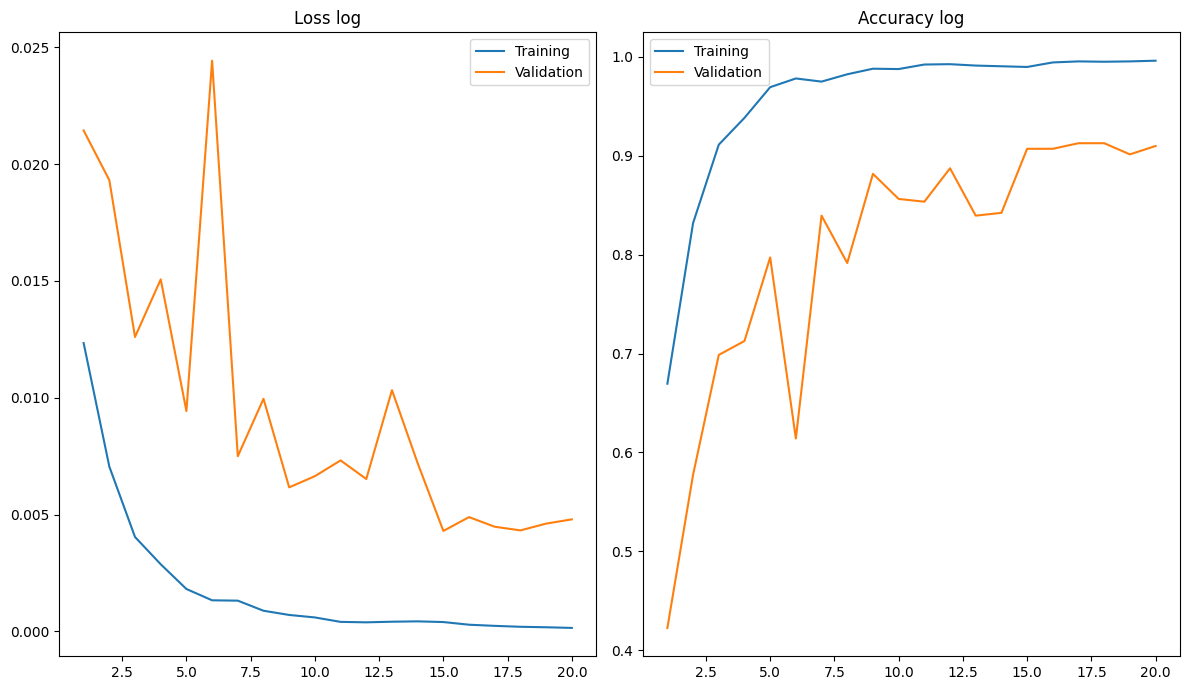

In [37]:
epochs = list(range(1, EPOCHS+1))
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 7))
axes[0].plot(epochs, train_loss)
axes[0].plot(epochs, val_loss)
axes[0].legend(["Training", "Validation"])
axes[0].set_title("Loss log")

axes[1].plot(epochs, train_acc)
axes[1].plot(epochs, val_acc)
axes[1].legend(["Training", "Validation"])
axes[1].set_title("Accuracy log")

plt.tight_layout()
plt.show()

In [38]:
def predict(x):
    img = Image.open(x).convert("RGB")
    img = transform(np.array(img))
    img = img.view(1, 3, 224, 224)
    best_model.eval()
    with torch.no_grad():
        if torch.cuda.is_available():
            img = img.cuda()
        
        out = best_model(img)
        
        return out.argmax(1).item()

In [39]:
pred = []
truth = []

for i in range(test.shape[0]):
    pred += [predict(test.iloc[i, 0])]
    truth += [test.iloc[i, 1]]

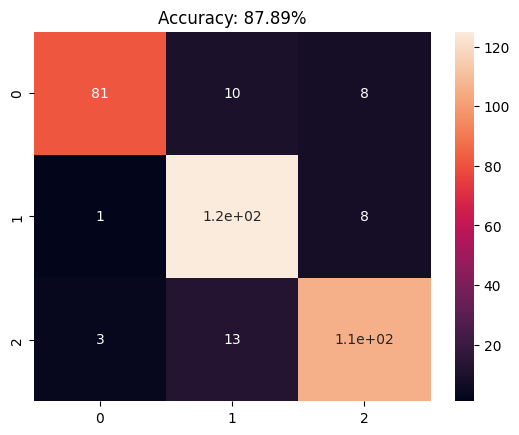

In [40]:
score = accuracy_score(truth, pred)
report = classification_report(truth, pred)
cm = confusion_matrix(truth, pred)
sns.heatmap(cm, annot=True)
plt.title("Accuracy: {}%".format(round(score*100, 2)))
plt.show()

In [42]:
print(report)

              precision    recall  f1-score   support

           0       0.95      0.82      0.88        99
           1       0.84      0.93      0.89       134
           2       0.87      0.87      0.87       122

    accuracy                           0.88       355
   macro avg       0.89      0.87      0.88       355
weighted avg       0.88      0.88      0.88       355



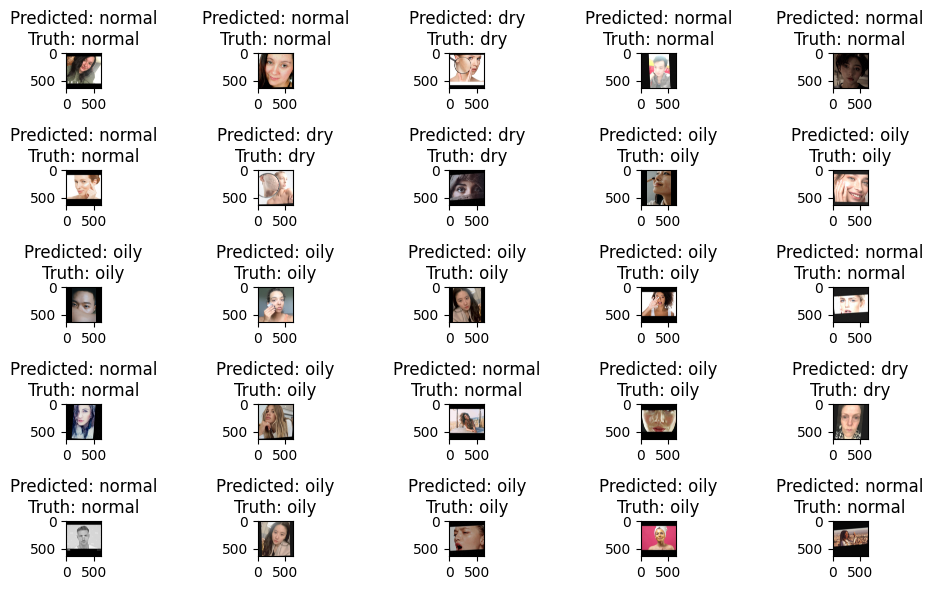

In [43]:
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10, 6))
index = 0
for i in range(5):
    for j in range(5):
        img = test.iloc[index, 0]
        img = Image.open(img).convert("RGB")
        axes[i][j].imshow(img)
        axes[i][j].set_title("Predicted: {}\nTruth: {}".format(index_label[pred[index]], index_label[truth[index]]))
        index += 1
        
plt.tight_layout()
plt.show()

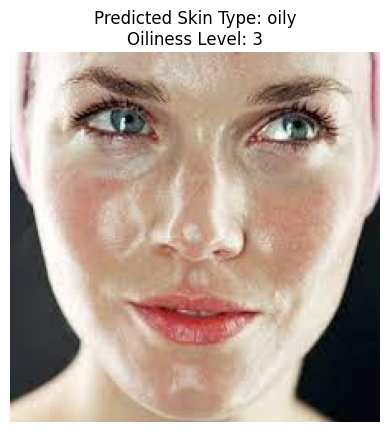

In [45]:
def predict_skin_type_and_oiliness_level(image_path):
    img = Image.open(image_path).convert("RGB")
    original_img = deepcopy(img)
    img = transform(np.array(img))
    img = img.view(1, 3, 224, 224)
    best_model.eval()
    with torch.no_grad():
        if torch.cuda.is_available():
            img = img.cuda()
        
        out = best_model(img)
        skin_type = index_label[out.argmax(1).item()]
        oiliness_level = get_oiliness_level(out.cpu().numpy())
        
        return original_img, skin_type, oiliness_level

def get_oiliness_level(predictions):
    oiliness_index = np.argmax(predictions)
    # Assuming the predictions are in the order of dry, normal, oily
    if oiliness_index == 0:
        return 1  # Dry or very low
    elif oiliness_index == 1:
        return 2  # Low
    elif oiliness_index == 2:
        return 3  # Medium
    else:
        return 4  # Very high

 

image_path = r"C:\Users\Anindya\Downloads\oil detection\oil detection\download (1).jpg"
original_img, skin_type, oiliness_level = predict_skin_type_and_oiliness_level(image_path)


# Show the original image
plt.imshow(original_img)
plt.title("Predicted Skin Type: {}\nOiliness Level: {}".format(skin_type, oiliness_level))
plt.axis("off")
plt.show()


In [46]:
import cv2
import torch

# Load the pre-trained face detection classifier
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Function to process the frame and predict the skin type, oiliness level, and face coordinates
def process_frame(frame):
    # Detect faces in the frame
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    
    if len(faces) > 0:
        (x, y, w, h) = faces[0]  # Assume only one face is detected
        face_roi = frame[y:y+h, x:x+w]
        
        # Convert the frame to RGB
        frame_rgb = cv2.cvtColor(face_roi, cv2.COLOR_BGR2RGB)
        # Resize and normalize the frame
        frame_resized = cv2.resize(frame_rgb, (IMG_SIZE, IMG_SIZE))
        frame_normalized = frame_resized / 255.0
        # Convert the frame to a tensor
        frame_tensor = torch.tensor(frame_normalized.transpose(2, 0, 1), dtype=torch.float32)
        frame_tensor = frame_tensor.unsqueeze(0)
        # Predict the skin type and oiliness level
        with torch.no_grad():
            if torch.cuda.is_available():
                frame_tensor = frame_tensor.cuda()
            out = best_model(frame_tensor)
            skin_type = index_label[out.argmax(1).item()]
            oiliness_level = get_oiliness_level(out.cpu().numpy())
        
        return skin_type, oiliness_level, (x, y, w, h)
    
    return None, None, None  # Return None if no face is detected

# Open the camera
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break
    
    # Process the frame
    skin_type, oiliness_level, face_coords = process_frame(frame)
    
    if skin_type is not None and oiliness_level is not None and face_coords is not None:
        (x, y, w, h) = face_coords
        # Draw a rectangle around the face
        cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)
        # Display the skin type and oiliness level on the face rectangle
        cv2.putText(frame, "Skin Type: {}".format(skin_type), (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
        cv2.putText(frame, "Oiliness Level: {}".format(oiliness_level), (x, y+h+20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
    
    # Display the frame with the face detection and prediction
    cv2.imshow('Skin Type and Oiliness Detection', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the camera and close all OpenCV windows
cap.release()
cv2.destroyAllWindows()


error: OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window.cpp:1272: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvShowImage'
